In [1]:
import math
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 60
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,AEF,2005-01-03 06:00:00,26.780
1,AEP,2005-01-03 06:00:00,34.210
2,ACH,2005-01-03 06:00:00,14.775
3,ABG,2005-01-03 06:00:00,13.800
4,AE,2005-01-03 06:00:00,17.690


### Check data

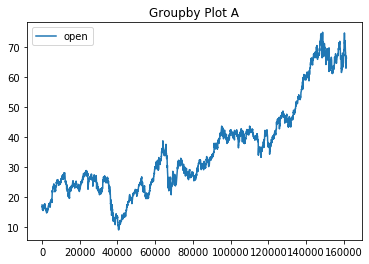

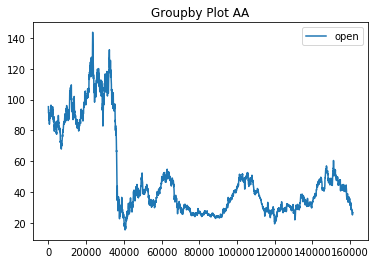

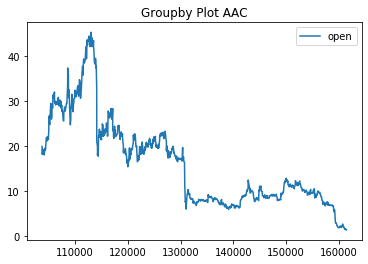

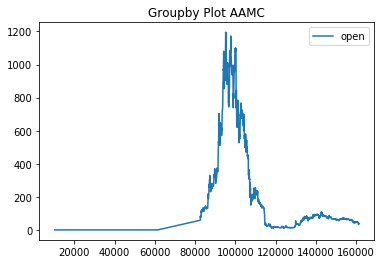

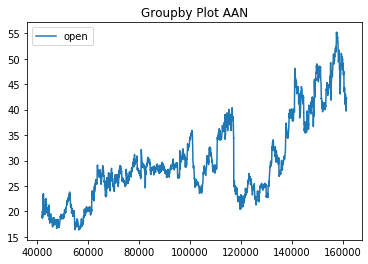

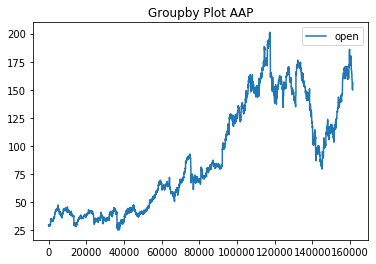

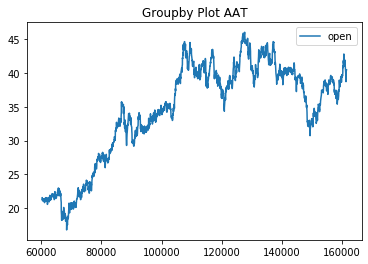

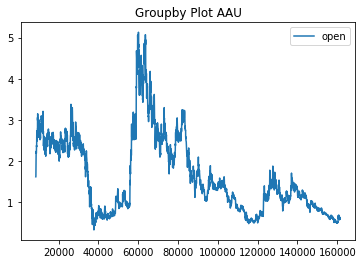

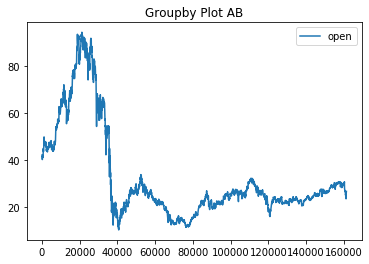

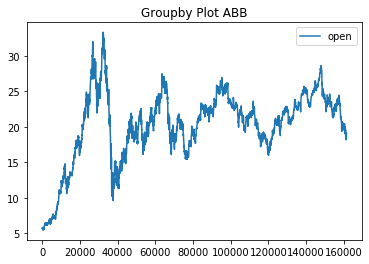

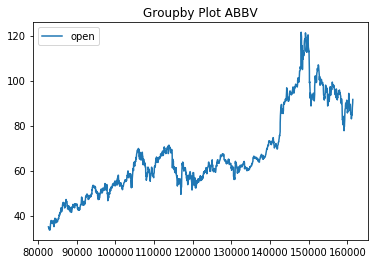

In [3]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

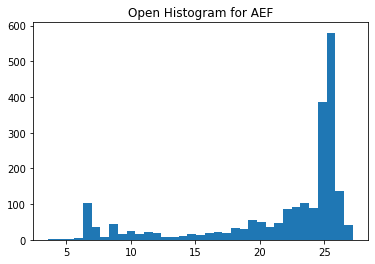

In [4]:
plt.hist(df.loc[df['symbol']==df['symbol'].values[0], 'open'], bins=35)
plt.title('Open Histogram for ' + df['symbol'].values[0])
plt.show()

### Clean data

In [5]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [6]:
df['target'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [7]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

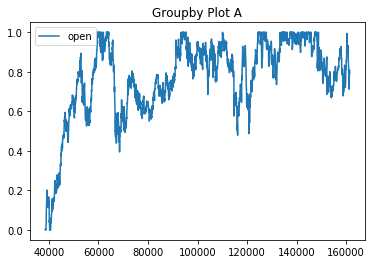

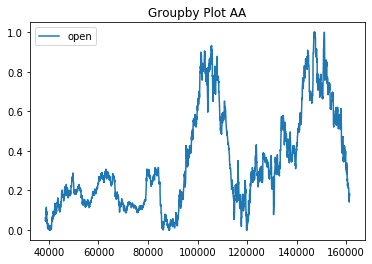

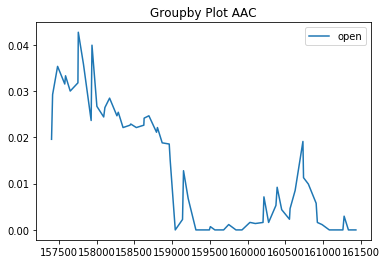

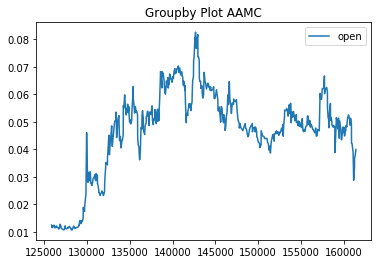

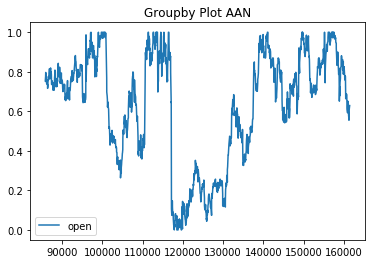

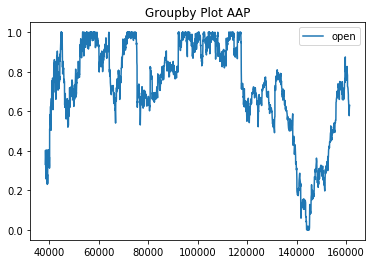

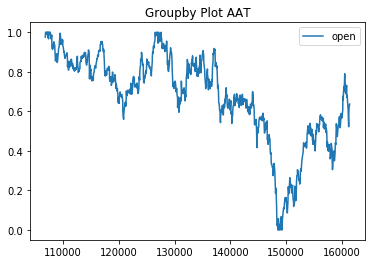

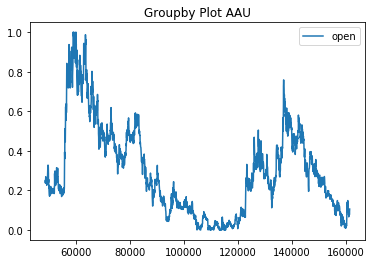

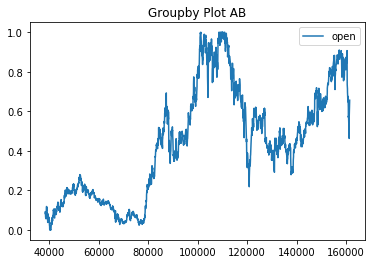

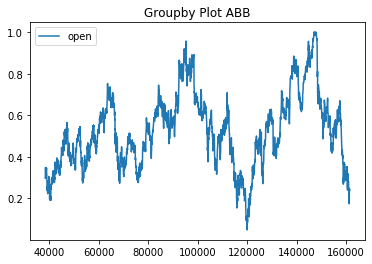

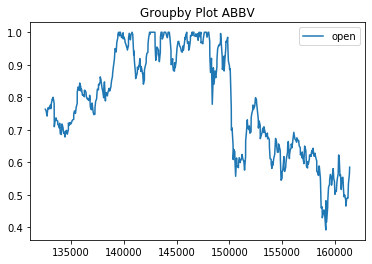

In [8]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

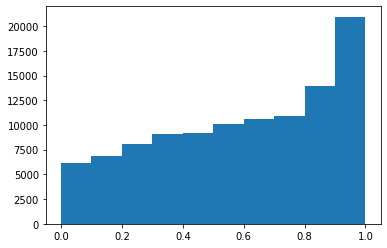

In [9]:
plt.hist(df['open'])
plt.show()

In [10]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(100815, 155)


,symbol,market_datetime,open,target,open_min,open_max,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
42572,AES,2009-05-12 05:00:00,0.215270,9.04000,4.980000,23.840000,0,0,0,0,...,0.087536,0.075942,0.067826,0.062029,0.060290,0.073043,0.075942,0.099130,0.055072,0.071304
42611,ABM,2009-05-12 05:00:00,0.251813,16.76000,11.900000,31.200000,0,0,0,0,...,0.290055,0.268508,0.279558,0.275691,0.278453,0.272376,0.274033,0.271823,0.267956,0.251381
42610,ADC,2009-05-12 05:00:00,0.269300,16.84000,9.410000,37.000000,0,0,0,0,...,0.270011,0.243821,0.339727,0.309111,0.313537,0.253781,0.216894,0.225009,0.237920,0.256732
42601,ABT,2009-05-12 05:00:00,0.322470,21.56084,17.962582,29.121011,0,0,0,0,...,0.673671,0.641509,0.670240,0.654803,0.645798,0.669382,0.636792,0.662950,0.635077,0.646655
42597,ABG,2009-05-12 05:00:00,0.269299,9.52000,1.950000,30.060000,0,0,0,0,...,0.089648,0.088225,0.082177,0.069015,0.062255,0.069370,0.092494,0.094628,0.103522,0.083600
42596,ADX,2009-05-12 05:00:00,0.267380,8.50000,6.000000,15.350000,0,0,0,0,...,0.091463,0.075610,0.074390,0.064634,0.079268,0.074390,0.109756,0.101220,0.128049,0.093902
42595,ABR,2009-05-12 05:00:00,0.059332,2.42000,0.430000,33.970000,0,0,0,0,...,0.023581,0.019547,0.032578,0.039094,0.043438,0.041266,0.040025,0.023891,0.024511,0.027304
42589,ACC,2009-05-12 05:00:00,0.353783,22.27000,15.350000,34.910000,0,0,0,0,...,0.167698,0.137310,0.198649,0.218908,0.196398,0.230163,0.271806,0.311761,0.289814,0.229038
42588,ABC,2009-05-12 05:00:00,0.297857,17.87000,13.770000,27.535000,0,0,0,0,...,0.284978,0.266844,0.264356,0.260444,0.258311,0.264711,0.277156,0.268267,0.257244,0.283911
42600,AEE,2009-05-12 05:00:00,0.125719,24.37000,19.780000,56.290000,0,0,0,0,...,0.149855,0.117925,0.125544,0.119376,0.107765,0.143687,0.145864,0.148766,0.146952,0.139332


### Train lstm

Epoch  0 Error:  30087.36328125
Epoch  50 Error:  10341.2060546875
Epoch  100 Error:  8712.63671875
Epoch  150 Error:  3618.048583984375
Epoch  200 Error:  3017.6298828125
Epoch  250 Error:  2531.942626953125
Epoch  300 Error:  2217.31591796875
Epoch  350 Error:  2032.2215576171875
Epoch  400 Error:  1885.51171875
Epoch  450 Error:  1775.1087646484375


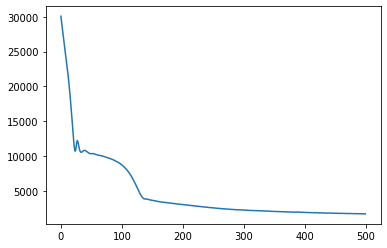

In [11]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = int(round(len(train_test)/2, -2))
model = nn_utils.TorchLSTM(train_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           train_y=train_test['open'].head(data_size), 
                           test_x=train_test.drop(cols_to_ignore, axis=1).tail(data_size), 
                           test_y=train_test['open'].tail(data_size),
                           n_layers=2,
                           n_epochs=500,
                           hidden_shape=300,
                           batch_size=int(data_size/100),
                           dropout=.1,
                           learning_rate=.0001,
                           device='cuda:0')

model.execute()
model.reset_network()

### Analyze predictions

In [12]:
test_df = model.test_df

temp = train_test[cols_to_ignore].tail(data_size).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,symbol_AAN,symbol_AAP,symbol_AAT,symbol_AAU,symbol_AB,symbol_ABB,...,open_98,open_99,actuals,prediction,symbol,market_datetime,open,open_min,open_max,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.808917,0.823248,0.928344,1.004822,AES,2014-07-18 05:00:00,0.928344,9.29,15.5700,15.120
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.866310,0.874191,0.890796,0.877299,AFL,2014-07-18 05:00:00,0.890797,15.86,33.6250,31.685
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.773060,0.775256,0.729868,0.766461,ADC,2014-07-18 05:00:00,0.729868,20.14,33.8000,30.110
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.898876,0.905618,0.980507,0.992322,ADX,2014-07-18 05:00:00,0.980507,8.81,13.9400,13.840
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.958241,0.960957,0.756015,0.836033,AE,2014-07-18 05:00:00,0.756015,16.60,90.2758,72.300


In [13]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['errors'] = test_df['prediction'] - test_df['actuals']

test_df.head(10)

,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,symbol_AAN,symbol_AAP,symbol_AAT,symbol_AAU,symbol_AB,symbol_ABB,...,prediction,symbol,market_datetime,open,open_min,open_max,target,prediction_mapped,actuals_mapped,errors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004822,AES,2014-07-18 05:00:00,0.928344,9.2900,15.5700,15.120,15.600283,15.120000,0.076478
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.877299,AFL,2014-07-18 05:00:00,0.890797,15.8600,33.6250,31.685,31.445223,31.685000,-0.013497
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.766461,ADC,2014-07-18 05:00:00,0.729868,20.1400,33.8000,30.110,30.609862,30.110000,0.036593
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992322,ADX,2014-07-18 05:00:00,0.980507,8.8100,13.9400,13.840,13.900614,13.840000,0.011815
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.836033,AE,2014-07-18 05:00:00,0.756015,16.6000,90.2758,72.300,78.195417,72.300001,0.080018
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.048747,AEO,2014-07-18 05:00:00,0.029927,10.1100,23.8100,10.520,10.777836,10.520000,0.018820
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.751926,ABM,2014-07-18 05:00:00,0.682800,17.5400,29.1100,25.440,26.239788,25.440000,0.069126
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.722240,AGCO,2014-07-18 05:00:00,0.654374,31.6300,64.4400,53.100,55.326701,53.099999,0.067867
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.739433,ABR,2014-07-18 05:00:00,0.700199,3.0799,8.2500,6.700,6.902844,6.700000,0.039234
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.595487,ACC,2014-07-18 05:00:00,0.594011,27.7000,48.0700,39.800,39.830073,39.800001,0.001476


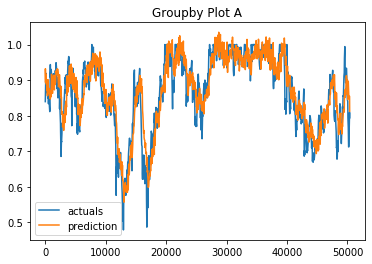

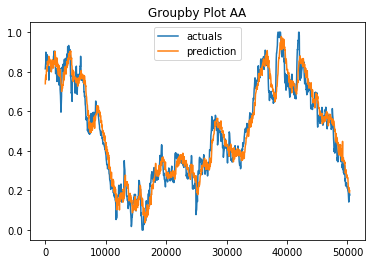

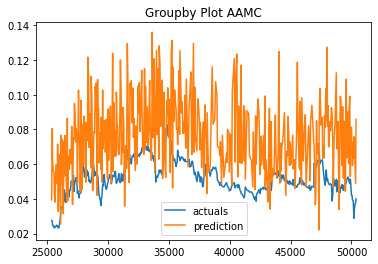

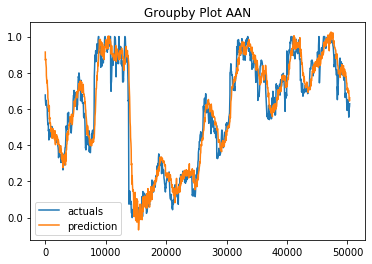

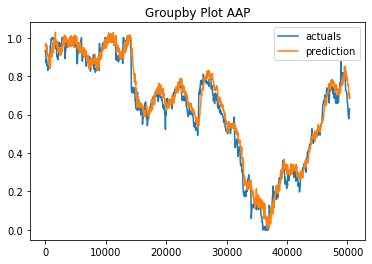

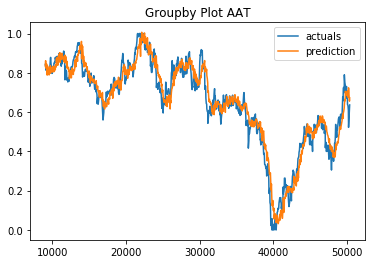

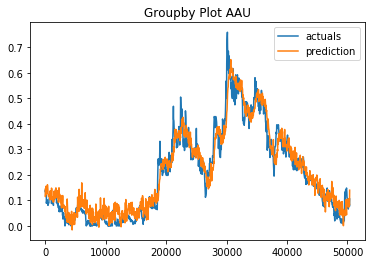

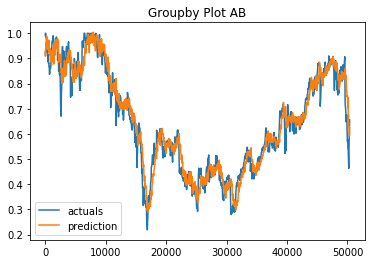

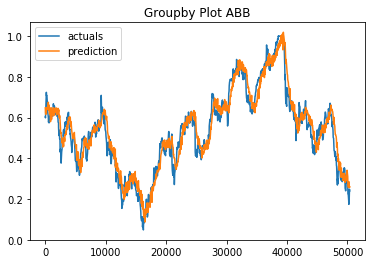

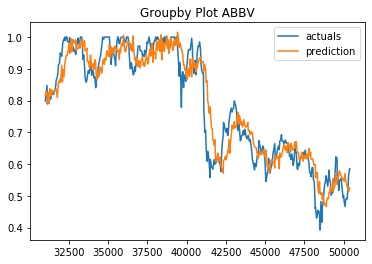

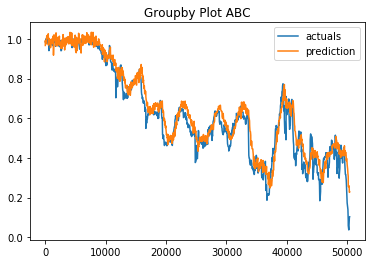

In [14]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['actuals', 'prediction'])

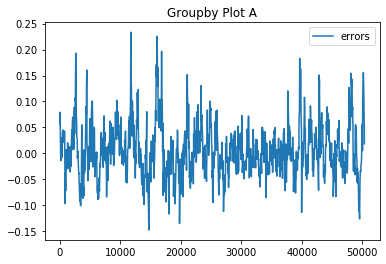

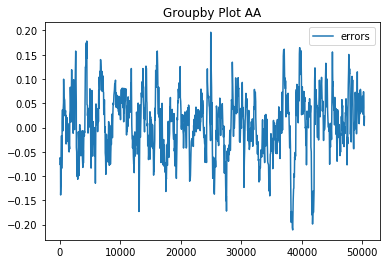

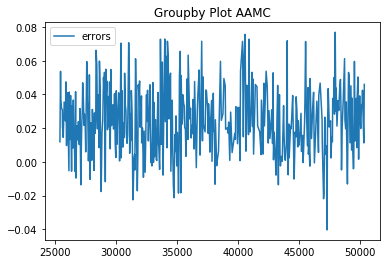

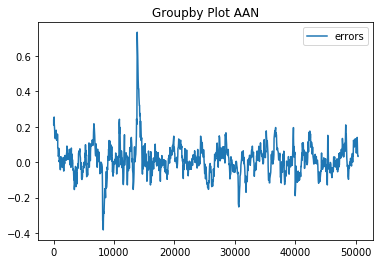

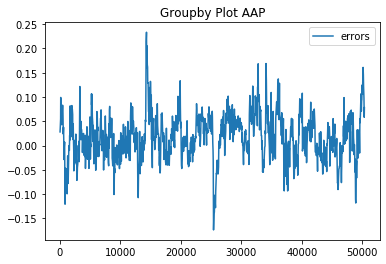

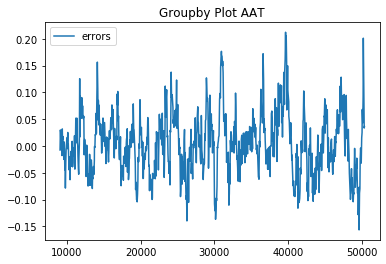

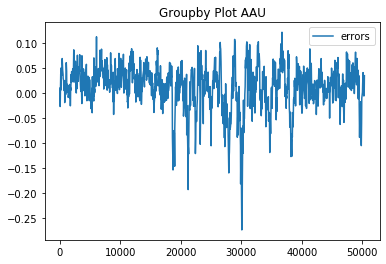

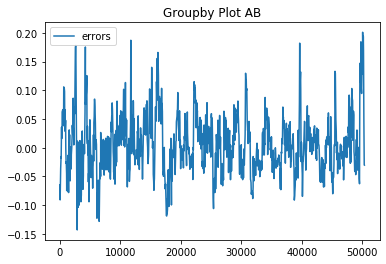

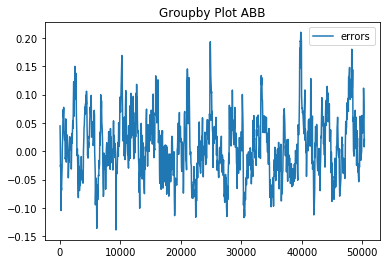

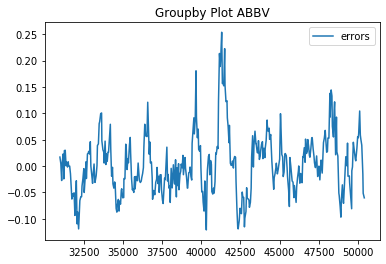

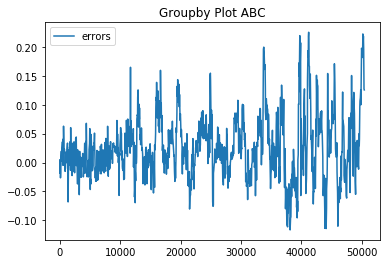

In [15]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['errors'])

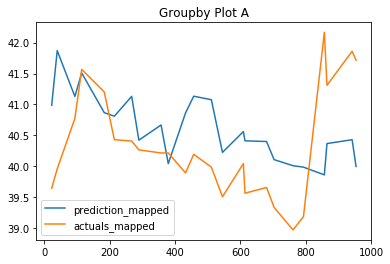

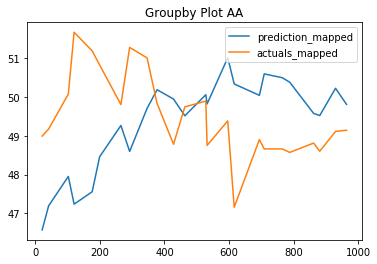

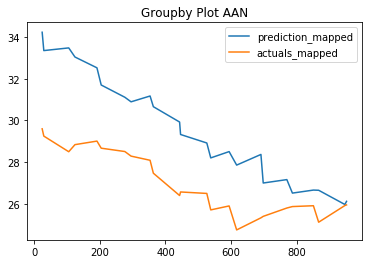

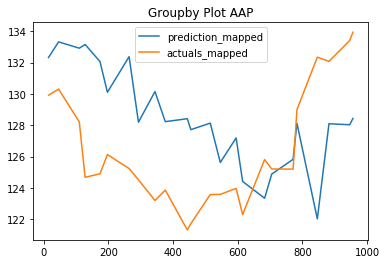

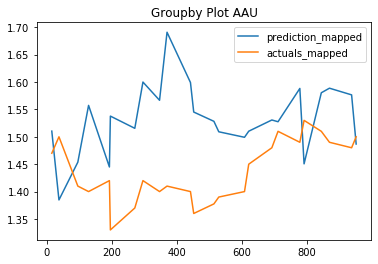

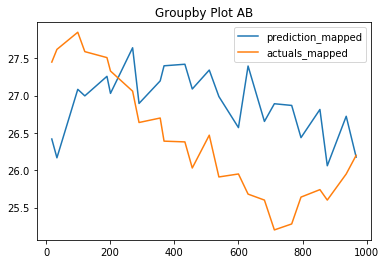

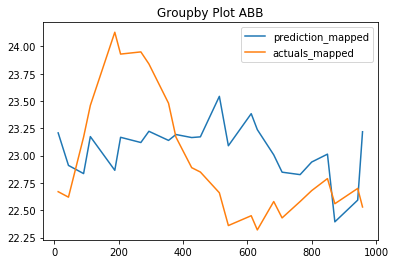

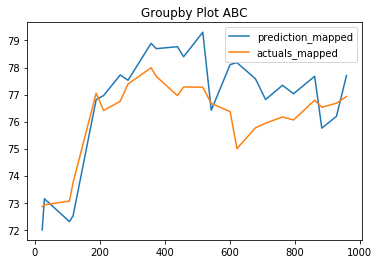

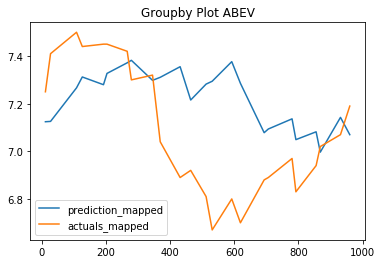

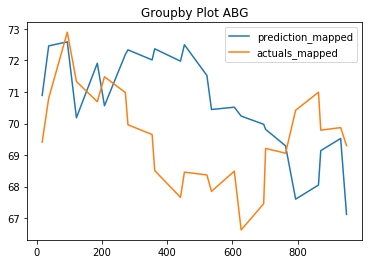

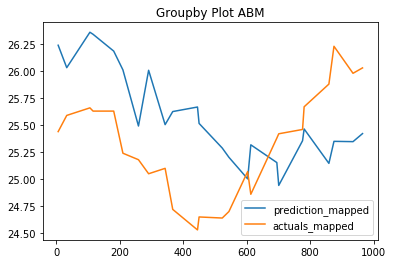

In [16]:
cluster_utils.plot_groupby(test_df.head(1000), 'symbol', lines=['prediction_mapped', 'actuals_mapped'])

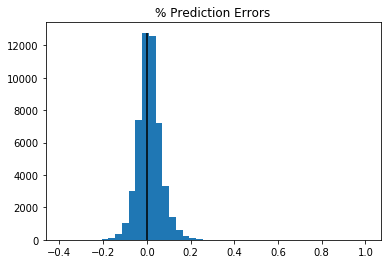

In [17]:
plt.title('% Prediction Errors')
plot = plt.hist(test_df['errors'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()

### Size bets

In [18]:
cols = ['symbol', 'market_datetime', 'prediction_mapped', 'actuals_mapped']

trades = test_df[cols]
trades = trades.join(test_df.groupby('symbol')['actuals_mapped'].shift(1), rsuffix='_t-1')
trades = trades.dropna()

# determine trade direction(s)
trades['current_trade'] = 'neutral'
trades.loc[trades['prediction_mapped'] > trades['actuals_mapped_t-1'], 'current_trade'] = 'long'
trades.loc[trades['prediction_mapped'] < trades['actuals_mapped_t-1'], 'current_trade'] = 'short'

# predict profits
trades['predicted_profits'] = abs(trades['prediction_mapped'] - trades['actuals_mapped_t-1'])

# calculate actual profits
trades['actual_profits'] = 0
trades.loc[trades['current_trade']=='long', 'actual_profits'] = trades.loc[trades['current_trade']=='long', 'actuals_mapped'] - trades.loc[trades['current_trade']=='long', 'actuals_mapped_t-1']
trades.loc[trades['current_trade']=='short', 'actual_profits'] = trades.loc[trades['current_trade']=='short', 'actuals_mapped_t-1'] - trades.loc[trades['current_trade']=='short', 'actuals_mapped']

trades[trades['symbol']==trades['symbol'].values[0]].head(10)

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits
27,ABEV,2014-07-21 05:00:00,7.125627,7.41,7.25,short,0.124373,-0.16
108,ABEV,2014-07-22 05:00:00,7.266532,7.50,7.41,short,0.143468,-0.09
126,ABEV,2014-07-23 05:00:00,7.312201,7.44,7.50,short,0.187799,0.06
192,ABEV,2014-07-24 05:00:00,7.279743,7.45,7.44,short,0.160257,-0.01
203,ABEV,2014-07-25 05:00:00,7.327119,7.45,7.45,short,0.122881,0.00
266,ABEV,2014-07-28 05:00:00,7.371700,7.42,7.45,short,0.078300,0.03
279,ABEV,2014-07-29 05:00:00,7.382132,7.30,7.42,short,0.037868,0.12
345,ABEV,2014-07-30 05:00:00,7.298024,7.32,7.30,short,0.001975,-0.02
369,ABEV,2014-07-31 05:00:00,7.310751,7.04,7.32,short,0.009249,0.28
431,ABEV,2014-08-01 05:00:00,7.355293,6.89,7.04,long,0.315293,-0.15


In [19]:
def kelly_criterion(predicted_win, predicted_loss, p_win, p_loss):
    bet_size = (predicted_win * p_win - predicted_loss * p_loss) / predicted_win
    return bet_size

def get_rolling_kelly_criterion(df, column='open', window_size=100):
    df['is_win'] = False
    df.loc[df['actual_profits'] > 0, 'is_win'] = True
    
    df['win_rate'] = (df['is_win'].rolling(window_size).sum()
                      /df['is_win'].rolling(window_size).count())
    
    df['estimated_loss'] = abs(df['actual_profits']).rolling(window_size).median()
    
    df['kelly'] = kelly_criterion(df['predicted_profits'], 
                                  df['estimated_loss'], 
                                  df['win_rate'], 
                                  1 - df['win_rate'])
    return df.drop(['is_win', 'win_rate'], axis=1)

trades = trades.groupby('symbol').apply(get_rolling_kelly_criterion)
trades = trades.dropna()
trades.tail(10)

,symbol,market_datetime,prediction_mapped,actuals_mapped,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,estimated_loss,kelly
50390,ABM,2018-12-31 06:00:00,28.920948,31.340000,31.040000,short,2.119052,-0.300000,0.405000,0.392527
50391,ACY,2018-12-31 06:00:00,10.717450,9.270000,8.709500,long,2.007950,0.560500,0.200000,0.439202
50392,ACRE,2018-12-31 06:00:00,13.695970,13.100000,13.090000,long,0.605970,0.010000,0.080000,0.366069
50393,ABC,2018-12-31 06:00:00,80.146900,74.090000,73.900000,long,6.246900,0.190000,0.890000,0.440189
50394,ACN,2018-12-31 06:00:00,151.188458,140.400001,141.010002,long,10.178456,-0.610001,1.114998,0.423037
50395,AEO,2018-12-31 06:00:00,18.712199,19.090000,19.350000,short,0.637801,0.260000,0.380000,0.090396
50396,ADM,2018-12-31 06:00:00,42.673774,40.840000,41.130000,long,1.543774,-0.290000,0.315000,0.422058
50397,ADC,2018-12-31 06:00:00,60.139447,59.330001,59.220000,long,0.919447,0.110000,0.430000,0.222134
50398,AEG,2018-12-31 06:00:00,4.743927,4.620000,4.600000,long,0.143927,0.020000,0.072500,0.187987
50399,AGCO,2018-12-31 06:00:00,55.655558,54.900000,54.880000,long,0.775558,0.020001,0.690000,0.111849


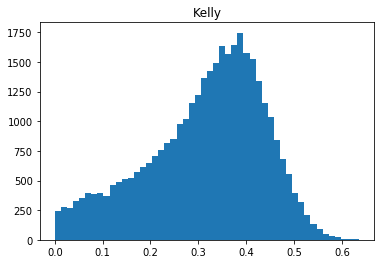

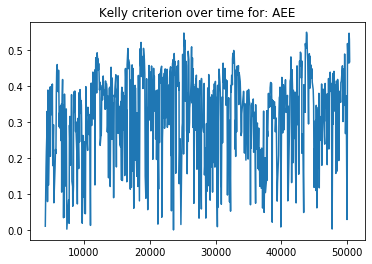

In [20]:
plt.title('Kelly')
plt.hist(trades.loc[trades['kelly'] > 0, 'kelly'], bins=50)
plt.show()

plt.title('Kelly criterion over time for: ' + trades['symbol'].values[0])
plt.plot(trades.loc[(trades['symbol']==trades['symbol'].values[0]) & (trades['kelly'] > 0), 'kelly'])
plt.show()

### Allocation method 1

In [21]:
# Get correlation matrix
correlations = df.pivot(index='market_datetime', columns='symbol', values='open')
correlations = correlations.rolling(100, min_periods=10).corr()
correlations.tail()

symbol                             A        AA       AAC      AAMC       AAN  \
market_datetime     symbol                                                     
2018-12-31 06:00:00 AFGE    0.255911  0.830092  0.525317  0.688266  0.829086   
                    AFL     0.318326  0.796778  0.573938  0.475225  0.825619   
                    AFT     0.048424  0.959704  0.771276  0.647116  0.950132   
                    AG     -0.349598  0.295871  0.485763  0.125126  0.139391   
                    AGCO    0.504761  0.690619  0.351970  0.548902  0.770621   

symbol                           AAP       AAT       AAU        AB       ABB  \
market_datetime     symbol                                                     
2018-12-31 06:00:00 AFGE    0.357622 -0.399376  0.151581  0.769530  0.807713   
                    AFL    -0.129986 -0.161400  0.547469  0.562696  0.898171   
                    AFT    -0.015578 -0.547992  0.303211  0.800276  0.913520   
                    AG     -0.589302 -0.673168  0.051433  0.012894  0.210153   
                    AGCO    0.131779 -0.045512  0.373199  0.614752  0.775012   

symbol                      ...       AER       AES       AFB       AFC  \
market_datetime     symbol  ...                                           
2018-12-31 06:00:00 AFGE    ...  0.824825  0.119061 -0.219056  0.841739   
                    AFL     ...  0.772329 -0.259925  0.096182  0.682030   
                    AFT     ...  0.930757 -0.028435 -0.070233  0.782443   
                    AG      ...  0.070634  0.033820 -0.391375 -0.041560   
                    AGCO    ...  0.775082 -0.046359  0.127997  0.631358   

symbol                           AFG      AFGE       AFL       AFT        AG  \
market_datetime     symbol                                                     
2018-12-31 06:00:00 AFGE    0.849553  1.000000  0.623758  0.843852  0.039204   
                    AFL     0.843673  0.623758  1.000000  0.775329  0.023032   
                    AFT     0.924733  0.843852  0.775329  1.000000  0.229108   
                    AG      0.021545  0.039204  0.023032  0.229108  1.000000   
                    AGCO    0.799531  0.581204  0.820845  0.662914 -0.117814   

symbol                          AGCO  
market_datetime     symbol            
2018-12-31 06:00:00 AFGE    0.581204  
                    AFL     0.820845  
                    AFT     0.662914  
                    AG     -0.117814  
                    AGCO    1.000000  

[5 rows x 50 columns]

In [54]:
def allocate_portfolio(trades, correlations, n_positions=5):
    
    # filter to only probably protiftable symbols
    potential_trades = trade[trade['kelly'] > 0]
    temp_correlations = correlations.droplevel('market_datetime')
    relevant_correlations = temp_correlations.loc[temp_correlations.index.isin(potential_trades['symbol']), temp_correlations.columns.isin(potential_trades['symbol'])]
    kelly_correlations = relevant_correlations.mul(pd.Series(trades['kelly'], index=trades['symbol']))
    
    # select best possible trade
    first_position = potential_trades.nlargest(1, 'kelly')
    symbols = first_position['symbol'].values.tolist()
    positions = [first_position]
    
    # determine next best trade
    for n_position in range(0, n_positions):
        least_correlated_potential = kelly_correlations.loc[~kelly_correlations.index.get_level_values('symbol').isin(symbols), symbols].sum(axis=1).abs().nsmallest(3).index.get_level_values('symbol')
        next_best_position = potential_trades[potential_trades['symbol'].isin(least_correlated_potential)].nlargest(1, 'kelly')['symbol'].values[0]
        symbols.append(next_best_position)
        positions.append(potential_trades[potential_trades['symbol'] == next_best_position])

    return positions

allocs = []
for day, trade in trades.groupby('market_datetime'):
    allocs.extend(allocate_portfolio(trade, correlations[correlations.index.get_level_values('market_datetime')==day]))

alloc_df = pd.concat(allocs)

In [ ]:
def normalize(df):
    df['kelly_adjusted'] = df['kelly']/df['kelly'].sum()
    return df

alloc_df['kelly_adjusted'] = 0
alloc_df = alloc_df.groupby('market_datetime').apply(normalize)

In [90]:
def calculate_position_dollar_values(df, budget):
    profits = ((df['kelly_adjusted'] * budget)/df['actuals_mapped_t-1']).astype(int) * (df['actuals_mapped'])
    return profits.sum()

budget = 1000
alloc_df['n_shares'] = 0
alloc_df['position_value'] = 0
alloc_df['profits_value'] = 0

temps = []
for day, allocation in alloc_df.groupby('market_datetime'):
    temp = calculate_position_dollar_values(allocation, budget)
    buget = temp.sum()
    temps.append(temp)
    

### Allocation method 2

In [48]:
def allocate_portfolio(trades, n_positions=10):
    
    # filter to only probably protiftable symbols
    potential_trades = trade[trade['kelly'] > 0]
    
    # select best possible trade
    first_position = potential_trades.nlargest(n_positions, 'kelly')
    positions = [first_position]

    return positions

allocs = []
for day, trade in trades.groupby('market_datetime'):
    allocs.extend(allocate_portfolio(trade))


1.965136102417123


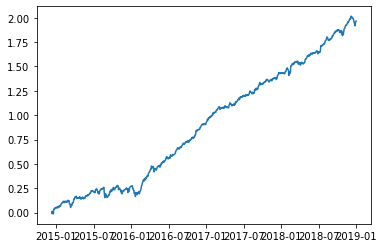

In [53]:
alloc_df = pd.concat(allocs)

alloc_df['kelly_adjusted'] = 0
alloc_df = alloc_df.groupby('market_datetime').apply(normalize)

alloc_df['kelly_profits'] = (alloc_df['actual_profits']/alloc_df['actuals_mapped_t-1']) * alloc_df['kelly_adjusted']

print(alloc_df['kelly_profits'].sum())

plt.plot(alloc_df.groupby('market_datetime').sum()['kelly_profits'].cumsum())
plt.show()

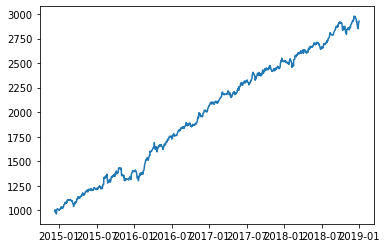

In [59]:
plt.plot(1000 * (1 + alloc_df.groupby('market_datetime').sum()['kelly_profits'].cumsum()))

Annualized P/L 0.372034


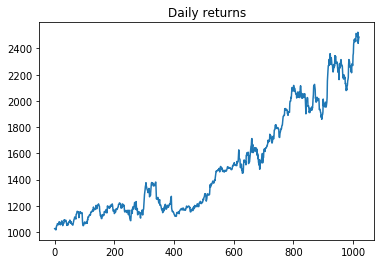

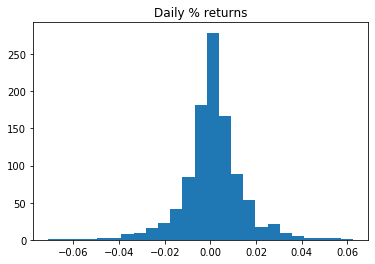

In [23]:
def calculate_annual_return(start_price, end_price, n_days):
    annual_return = (1+((end_price-start_price)/start_price))**(365/n_days)-1
    return annual_return

annualized_return = calculate_annual_return(budgets[0], budgets[-1], len(budgets))
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Daily returns')
plt.plot(budgets)
plt.show()

plt.title('Daily % returns')
plt.hist([((budgets[n]-budgets[n-1])/budgets[n-1]) for n in range(1, len(budgets))], bins=25)
plt.show()

### Compare raw returns

In [24]:
start = trades[trades['market_datetime']==trades['market_datetime'].values[1]]
end = trades[trades['market_datetime']==trades['market_datetime'].values[-1]]
comp = pd.merge(start, end, on='symbol')

print('Start date: ' + str(comp['market_datetime_x'].values[0]))
print('End date:   ' + str(comp['market_datetime_y'].values[0]))
print('\n')
print(calculate_annual_return(comp['actuals_mapped_y'], comp['actuals_mapped_x'], (comp['market_datetime_y'] - comp['market_datetime_x']).astype('timedelta64[D]')).sort_values(ascending=False))

Start date: 2014-12-09T06:00:00.000000000
End date:   2018-12-28T06:00:00.000000000


19    0.150090
24    0.141770
23    0.112336
15    0.084520
13    0.077515
8     0.053955
17    0.035442
6     0.034537
9     0.030245
12    0.028675
7     0.019967
21   -0.005330
20   -0.007582
1    -0.015655
18   -0.024959
10   -0.042756
3    -0.058119
0    -0.094240
14   -0.097822
5    -0.098355
4    -0.104116
11   -0.104914
25   -0.106500
16   -0.114061
22   -0.119491
2    -0.146459
dtype: float64


In [297]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn, functional, optim, autograd

from finance.utilities import utils
from finance.data_science.utilities import cluster_utils


class TorchRL(nn.Module):
    def __init__(self, 
                 train,
                 test=pd.DataFrame(),
                 cross_correlations=pd.DataFrame(),
                 bias=True,
                 n_dropout=0,
                 hidden_shape=16,
                 output_shape=1,
                 batch_size=None,
                 n_epochs=10,
                 learning_rate=.0001,
                 device='cuda'
                ):
        super(TorchRL, self).__init__()
        torch.manual_seed(3)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # Network params
        self.bias = bias
        self.n_dropout = n_dropout
        self.input_shape = train.shape[1]
        self.hidden_shape = hidden_shape
        self.output_shape = output_shape
        self.batch_size = batch_size if batch_size else len(test)
        self.train_input = (
            int(len(train)/self.batch_size), 
            self.batch_size, 
            self.input_shape
        )
        self.test_input = (
            int(len(test)/self.batch_size), 
            self.batch_size, 
            self.input_shape
        )

        # Learning params
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.device = device

        # Data
        self.x_columns = train.columns
        self.train_df = None
        self.test_df = None
        
        self.train = torch.tensor(
            train.values).to(self.device).float().detach().requires_grad_(True).view(self.train_input)
        self.test = torch.tensor(
            test.values).to(self.device).float().detach().requires_grad_(True).view(self.test_input)
        self.corr_tensor = torch.Tensor(cross_correlations).to(self.device)

        # Network
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
        self.linear_one = nn.Linear(self.input_shape, self.hidden_shape).to(self.device)
        self.linear_two = nn.Linear(self.hidden_shape, self.output_shape).to(self.device)
    
    def reset_network(self):
        self.linear_one.reset_parameters()
        self.linear_two.reset_parameters()
   
    @property
    def loss_function(self):
        loss = nn.L1Loss(reduction='sum').to(self.device)
        return loss
    
    @property
    def optimizer(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, train=True):
        data = self.train if train else self.test
        output = self.linear_one(data)
        output = self.relu(output)
        output = self.linear_two(output)
        output = self.relu(output)
        return output
    
    def dropout(self, output):
        dropout = nn.Dropout(0.9)
        return dropout(output)
    
    def execute(self):
        optimizer = self.optimizer
        history = np.zeros(self.n_epochs)

        for epoch in range(self.n_epochs):
            prediction = self.forward()
            
            multiply_pred = prediction.view(
                prediction.shape[0], 1, -1).mul(self.corr_tensor).mul(prediction.view(prediction.shape[0], -1, 1))
            loss = multiply_pred.sum(dim=1).view(prediction.shape[0], 1, -1)
            sigmoid_loss = self.sigmoid(loss)

            if epoch % int(self.n_epochs/10) == 0:
                print("Epoch ", epoch, "Error: ", sigmoid_loss.mean())
            
            history[epoch] = loss.mean()

            optimizer.zero_grad()
            sigmoid_loss.sum().backward()
            optimizer.step()
        
        plt.plot(history)
        return sigmoid_loss
    
    def predict(self):
        self.eval()
        prediction = self.forward(train=False)
        return prediction


In [298]:
trades[['market_datetime', 'symbol', 'kelly']].head()

,market_datetime,symbol,kelly
4174,2014-12-09 06:00:00,AEE,0.011191
4176,2014-12-09 06:00:00,AES,0.139650
4178,2014-12-09 06:00:00,ADC,0.194692
4181,2014-12-09 06:00:00,AGCO,-0.485820
4184,2014-12-09 06:00:00,AEO,0.442924


In [299]:
trades_pivot = trades.pivot(index='market_datetime', columns='symbol', values='kelly').fillna(0)
trades_pivot.head()

symbol,A,AA,AAMC,AAN,AAP,AAT,AAU,AB,ABB,ABBV,...,AEP,AER,AES,AFB,AFC,AFG,AFL,AFT,AG,AGCO
market_datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-09 06:00:00,0.419008,0.256315,0.0,0.350202,-0.239845,0.0,0.361360,0.400811,0.410885,0.0,...,0.000000,0.000000,0.139650,0.000000,0.000000,0.000000,0.322671,0.000000,0.000000,-0.485820
2014-12-10 06:00:00,0.384443,0.468108,0.0,0.350918,0.025147,0.0,0.364073,0.508809,0.474456,0.0,...,0.176776,0.319226,0.188179,0.359972,0.473271,-0.388501,-0.202545,0.362698,0.407213,0.394234
2014-12-11 06:00:00,0.266312,0.446638,0.0,0.329001,0.043548,0.0,-0.185692,0.484894,0.429260,0.0,...,0.221597,0.346874,-0.075571,0.409888,0.412747,-0.145184,0.145992,0.336471,-0.932253,0.387013
2014-12-12 06:00:00,0.436407,0.458381,0.0,0.390458,0.260566,0.0,0.369601,0.485632,0.457401,0.0,...,0.273202,0.334167,0.334705,0.303923,0.374566,0.348501,0.263381,0.311389,0.103785,0.360284
2014-12-15 06:00:00,0.415926,0.485339,0.0,0.442164,0.344073,0.0,0.396912,0.419746,0.438420,0.0,...,0.086333,0.325207,0.360095,0.281745,0.073484,0.386698,0.148276,-0.499843,-0.190663,0.364086


In [300]:
corrs = correlations[correlations.index.get_level_values('market_datetime').isin(trades['market_datetime'])]
corrs = corrs.loc[corrs.index.get_level_values('symbol').isin(trades['symbol']), trades['symbol'].unique()].fillna(0)

temp = []
for date, data in corrs.groupby('market_datetime'):
    temp.append(data.values)

corrs = np.array(temp)

Epoch  0 Error:  tensor(0.5639, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  1000 Error:  tensor(0.4969, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  2000 Error:  tensor(0.4867, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  3000 Error:  tensor(0.4762, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  4000 Error:  tensor(0.4693, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  5000 Error:  tensor(0.4645, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  6000 Error:  tensor(0.4610, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  7000 Error:  tensor(0.4583, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  8000 Error:  tensor(0.4559, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch  9000 Error:  tensor(0.4536, device='cuda:0', grad_fn=<MeanBackward1>)


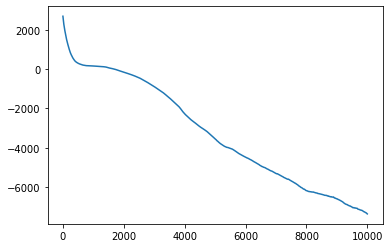

In [335]:
agent = TorchRL(trades_pivot, 
                trades_pivot, 
                cross_correlations=corrs, 
                batch_size=1,
                n_epochs=10000,
                output_shape=trades['symbol'].nunique()
               )

temp = agent.execute()